# Perform sentimental analysis:
1) Extract reviews of any product from ecommerce website like amazon

2) Perform emotion mining

#### Import Libraries

In [1]:
import re
import nltk
import spacy
import codecs
import requests

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from textblob import TextBlob
from bs4 import BeautifulSoup
from tqdm import tqdm_notebook
from wordcloud import WordCloud
from nltk.corpus import stopwords
from bs4 import BeautifulSoup as bs
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

import warnings
warnings.filterwarnings('ignore')

#### web-scraping 

In [ ]:
#Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36Mozilla/5.0 (Windows NT 6.0; WOW64; rv:24.0) Gecko/20100101 Firefox/24.0

In [49]:
headers = {'authority': 'www.amazon.in',
           'accept-language': 'en-US,en;q=0.9',
           'referer': 'https://www.amazon.in/Lavie-Yalta-Womens-Satchel-Handbag/dp/B08Z83K1C9/ref=sr_1_9?crid=3P6WO2ILTFZP5&keywords=women%2Bbags&qid=1683865044&sprefix=women%2Bbag%2Caps%2C319&sr=8-9&th=1',
           'user-agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/109.0.0.0 Safari/537.36'}


#### Looping

In [50]:
def get_soup(url):
    r = requests.get(url, headers=headers,
    params={'url': url, 'wait': 2})
    soup = BeautifulSoup(r.text, 'html.parser')
    return soup

In [51]:
reviewlist = []

def get_reviews(soup):
    reviews = soup.find_all('div', {'data-hook': 'review'})
    try:
        for item in reviews:
            review = {'Title': item.find('a', {'data-hook': 'review-title'}).text.strip(),
                      'Rating':float(item.find('i', {'data-hook': 'review-star-rating'}).text.replace('out of 5 stars', '').strip()),
                      'Review':item.find('span', {'data-hook': 'review-body'}).text.strip(),
                      'Review_Date':item.find('span', {'data-hook': 'review-date'}).text.replace('Reviewed in India 🇮🇳 on', 'Reviewed in India on').strip()}
            reviewlist.append(review)
    except:
        pass

In [52]:
for x in tqdm_notebook(range(160)):
    soup = get_soup(f'https://www.amazon.in/Lavie-Yalta-Womens-Satchel-Handbag/product-reviews/B08Z83K1C9/ref=cm_cr_dp_d_show_all_btm?ie=UTF8&reviewerType=all_reviews={x}')
    get_reviews(soup)
    if not soup.find('li', {'class': 'a-disabled a-last'}):
        pass
    else:
        break

  0%|          | 0/160 [00:00<?, ?it/s]

#### Saving in dataframe and exporting to csv 

In [53]:
bag_review = pd.DataFrame(reviewlist)
bag_review

,Title,Rating,Review,Review_Date
0,Good Product,4.0,Liked it,Reviewed in India on 17 March 2023
1,Big,3.0,Slightly bigger than I expected,Reviewed in India on 4 April 2023
2,Superb Quality and design,5.0,I was looking for a slightly big purse for my ...,Reviewed in India on 9 May 2023
3,Packing needs ro improve,3.0,"Overall the bag is good. However, i was truly...",Reviewed in India on 5 January 2023
4,Sexy product,5.0,The quality is so premium and look is so sexy ...,Reviewed in India on 8 May 2023
...,...,...,...,...
1595,Low quality bag,2.0,Could use it only for 2months…the colour comes...,Reviewed in India on 14 April 2023
1596,Amazing,5.0,The handbag looks fantastic and the color is a...,Reviewed in India on 10 May 2023
1597,Amazing Handbag,5.0,The handbag is very spacious and easy to carry...,Reviewed in India on 10 May 2023
1598,Excellent,5.0,I loved this bag ...It's spacious and has mult...,Reviewed in India on 10 May 2023


In [54]:
bag_review["Review_Date"] = bag_review["Review_Date"].replace('Reviewed in India on','', regex=True)

In [55]:
bag_review.head()

,Title,Rating,Review,Review_Date
0,Good Product,4.0,Liked it,17 March 2023
1,Big,3.0,Slightly bigger than I expected,4 April 2023
2,Superb Quality and design,5.0,I was looking for a slightly big purse for my ...,9 May 2023
3,Packing needs ro improve,3.0,"Overall the bag is good. However, i was truly...",5 January 2023
4,Sexy product,5.0,The quality is so premium and look is so sexy ...,8 May 2023


In [56]:
bag_review.to_csv('bag_review_amazon.csv')

#### Load Dataset 

In [57]:
reviews = pd.read_csv('bag_review_amazon.csv')
reviews.drop(['Unnamed: 0'],inplace=True,axis=1)
reviews.head(2)

,Title,Rating,Review,Review_Date
0,Good Product,4.0,Liked it,17 March 2023
1,Big,3.0,Slightly bigger than I expected,4 April 2023


#### EDA

In [58]:
reviews.Rating.describe()

count    1600.00000
mean        4.20000
std         1.07737
min         2.00000
25%         3.00000
50%         5.00000
75%         5.00000
max         5.00000
Name: Rating, dtype: float64

In [59]:
reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600 entries, 0 to 1599
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Title        1600 non-null   object 
 1   Rating       1600 non-null   float64
 2   Review       1600 non-null   object 
 3   Review_Date  1600 non-null   object 
dtypes: float64(1), object(3)
memory usage: 50.1+ KB


In [60]:
reviews.isna().sum()

Title          0
Rating         0
Review         0
Review_Date    0
dtype: int64

In [61]:
reviews.dropna(subset=['Review'],inplace=True)
reviews

,Title,Rating,Review,Review_Date
0,Good Product,4.0,Liked it,17 March 2023
1,Big,3.0,Slightly bigger than I expected,4 April 2023
2,Superb Quality and design,5.0,I was looking for a slightly big purse for my ...,9 May 2023
3,Packing needs ro improve,3.0,"Overall the bag is good. However, i was truly...",5 January 2023
4,Sexy product,5.0,The quality is so premium and look is so sexy ...,8 May 2023
...,...,...,...,...
1595,Low quality bag,2.0,Could use it only for 2months…the colour comes...,14 April 2023
1596,Amazing,5.0,The handbag looks fantastic and the color is a...,10 May 2023
1597,Amazing Handbag,5.0,The handbag is very spacious and easy to carry...,10 May 2023
1598,Excellent,5.0,I loved this bag ...It's spacious and has mult...,10 May 2023


In [62]:
n=len(pd.unique(reviews['Review_Date']))
n

7

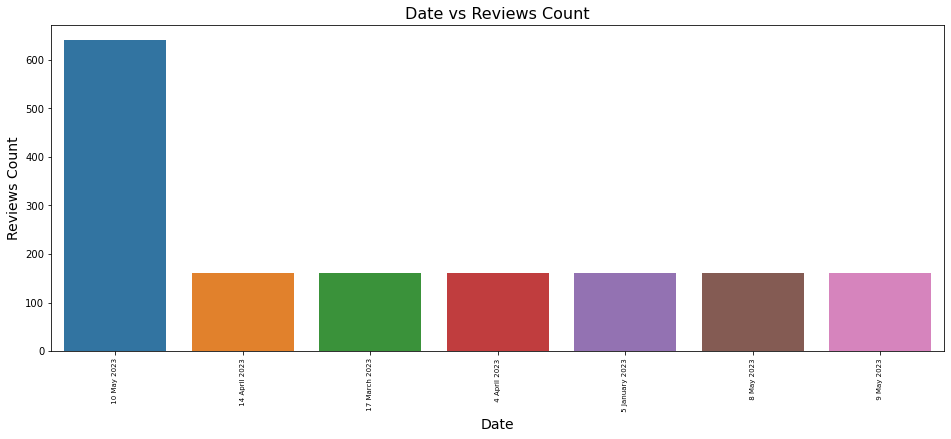

In [63]:
#Creating a dataframe
dayreview = pd.DataFrame(reviews.groupby('Review_Date')['Review'].count()).reset_index()
dayreview['Date'] = dayreview['Review_Date']
dayreview.sort_values(by = ['Review_Date'])

#Plotting the graph
plt.figure(figsize=(16,6))
sns.barplot(x = "Date", y = "Review", data = dayreview)
plt.title('Date vs Reviews Count', fontsize=16)
plt.xticks(rotation=90,fontsize=7)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Reviews Count',fontsize=14)
plt.show()


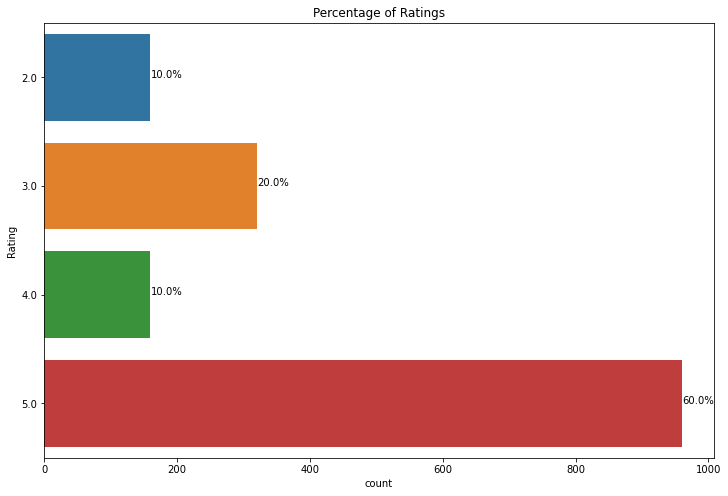

In [64]:
plt.figure(figsize=(12,8))
plt.title('Percentage of Ratings')
ax = sns.countplot(y = 'Rating', data = reviews)
total = len(reviews)
for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_width()/total)
        x = p.get_x() + p.get_width() + 0.02
        y = p.get_y() + p.get_height()/2
        ax.annotate(percentage, (x, y))

#### BasicText Preprocessing for Sentiment Analysis

#### Spelling Correction

In [65]:
reviews['Review'][:5].apply(lambda x: str(TextBlob(x).correct()))

0                                             Liked it
1                      Slightly bigger than I expected
2    I was looking for a slightly big purse for my ...
3    Overall the bag is good. However,  i was truly...
4    The quality is so premium and look is so sex t...
Name: Review, dtype: object

In [67]:
bags_review = reviews[['Review']]
bags_review

,Review
0,Liked it
1,Slightly bigger than I expected
2,I was looking for a slightly big purse for my ...
3,"Overall the bag is good. However, i was truly..."
4,The quality is so premium and look is so sexy ...
...,...
1595,Could use it only for 2months…the colour comes...
1596,The handbag looks fantastic and the color is a...
1597,The handbag is very spacious and easy to carry...
1598,I loved this bag ...It's spacious and has mult...


#### Resetting index

In [70]:
bags_review.reset_index(drop=True, inplace=True)

In [71]:
stop_words = stopwords.words('english')
bags_review['Review'] = bags_review['Review'].apply(lambda x: " ".join(x.lower() for x in str(x).split() if x not in stop_words))


#### Lemmatizer 

In [76]:
lemmatizer = WordNetLemmatizer()
# Removing punctuation, making str to lower, applying Lemmatizer, Removing Stop words
corpus=[]
for i in tqdm_notebook(range(0, len(bags_review))):
    cleaned = re.sub('[^a-zA-Z]', " ", bags_review["Review"][i])
    cleaned = cleaned.lower()
    cleaned = cleaned.split()
    cleaned = [lemmatizer.lemmatize(word) for word in cleaned if word not in stopwords.words("english")]
    cleaned = ' '.join(cleaned)
    corpus.append(cleaned)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [77]:
#Saving cleaned data to compare with original data, to ckeck amount of information lost
dataframe = pd.DataFrame({"Clean_Reviews": corpus,"Uncleaned_Reviews": bags_review.Review})
dataframe.head()


,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."


#### Text Pre-processing Techniques

#### Removing '@names'

In [78]:
def remove_pattern(text, pattern_regex):
    r = re.findall(pattern_regex, text)
    for i in r:
        text = re.sub(i, '', text)
    
    return text

In [79]:
# We are keeping cleaned tweets in a new column called 'tidy_tweets'
dataframe['Clean_Reviews'] = np.vectorize(remove_pattern)(dataframe['Clean_Reviews'], "@[\w]*")
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Removing links 

In [80]:
cleaned_reviews = []

for index, row in dataframe.iterrows():
    words_without_links = [word for word in row.Clean_Reviews.split() if 'http' not in word]
    cleaned_reviews.append(' '.join(words_without_links))

dataframe['Clean_Reviews'] = cleaned_reviews
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Removing Review with empty text

In [81]:
dataframe = dataframe[dataframe['Clean_Reviews']!='']
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Droping duplicate rows 

In [82]:
dataframe.drop_duplicates(subset=['Clean_Reviews'], keep=False)
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Function to remove emoji

In [83]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [84]:
dataframe['Clean_Reviews']=dataframe['Clean_Reviews'].apply(lambda x: remove_emoji(x))
dataframe.head(10)


,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Removing Stop words

In [85]:
with codecs.open("stop.txt", "r", encoding="ISO-8859-1") as s:
    stop = s.read()
    print(stop[:101])

a
a's
able
about
above
according
accordingly
across
actually
after
afterwards
again
again


In [86]:
stop.split(" ")

["a\r\na's\r\nable\r\nabout\r\nabove\r\naccording\r\naccordingly\r\nacross\r\nactually\r\nafter\r\nafterwards\r\nagain\r\nagainst\r\nain't\r\nall\r\nallow\r\nallows\r\nalmost\r\nalone\r\nalong\r\nalready\r\nalso\r\nalthough\r\nalways\r\nam\r\namong\r\namongst\r\nan\r\nand\r\nanother\r\nany\r\nanybody\r\nanyhow\r\nanyone\r\nanything\r\nanyway\r\nanyways\r\nanywhere\r\napart\r\nappear\r\nappreciate\r\nappropriate\r\nare\r\naren't\r\naround\r\nas\r\naside\r\nask\r\nasking\r\nassociated\r\nat\r\navailable\r\naway\r\nawfully\r\nb\r\nbe\r\nbecame\r\nbecause\r\nbecome\r\nbecomes\r\nbecoming\r\nbeen\r\nbefore\r\nbeforehand\r\nbehind\r\nbeing\r\nbelieve\r\nbelow\r\nbeside\r\nbesides\r\nbest\r\nbetter\r\nbetween\r\nbeyond\r\nboth\r\nbrief\r\nbut\r\nby\r\nc\r\nc'mon\r\nc's\r\ncame\r\ncan\r\ncan't\r\ncannot\r\ncant\r\ncause\r\ncauses\r\ncertain\r\ncertainly\r\nchanges\r\nclearly\r\nco\r\ncom\r\ncome\r\ncomes\r\nconcerning\r\nconsequently\r\nconsider\r\nconsidering\r\ncontain\r\ncontaining\r\nconta

In [87]:
my_stop_words = stopwords.words('english')
sw_list = [stop]
my_stop_words.extend(sw_list)
stopwords_set = set(my_stop_words)
cleaned_tweets = []

for index, row in dataframe.iterrows():
    
    # filerting out all the stopwords 
    words_without_stopwords = [word for word in row.Clean_Reviews.split() if not word in stopwords_set and '#' not in word.lower()]
    
    # finally creating tweets list of tuples containing stopwords(list) and sentimentType 
    cleaned_tweets.append(' '.join(words_without_stopwords))
    
dataframe['Clean_Reviews'] = cleaned_tweets
dataframe.head(10)


,Clean_Reviews,Uncleaned_Reviews
0,liked,liked
1,slightly bigger expected,slightly bigger expected
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou..."


#### Tokenize 'Clean_Reviews'

In [91]:
TextBlob(dataframe['Clean_Reviews'][1]).words

WordList(['slightly', 'bigger', 'expected'])

In [92]:
tokenized_review = dataframe['Clean_Reviews'].apply(lambda x: x.split())
tokenized_review.head(10)

0                                              [liked]
1                         [slightly, bigger, expected]
2    [looking, slightly, big, purse, office, purpos...
3    [overall, bag, good, however, truly, disappoin...
4    [quality, premium, look, sexy, forgot, old, ba...
5    [could, use, month, colour, come, every, time,...
6    [handbag, look, fantastic, color, awesome, eas...
7    [handbag, spacious, easy, carry, strap, good, ...
8    [loved, bag, spacious, multiple, pocket, super...
9    [totally, love, bag, quality, amazing, spaciou...
Name: Clean_Reviews, dtype: object

In [93]:
dataframe['Tokenized_Reviews'] = dataframe['Clean_Reviews'].apply(lambda x: nltk.word_tokenize(x))
dataframe.head(10)

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews
0,liked,liked,[liked]
1,slightly bigger expected,slightly bigger expected,"[slightly, bigger, expected]"
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...,"[looking, slightly, big, purse, office, purpos..."
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ...","[overall, bag, good, however, truly, disappoin..."
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col...","[quality, premium, look, sexy, forgot, old, ba..."
5,could use month colour come every time use fak...,could use 2months…the colour comes every time ...,"[could, use, month, colour, come, every, time,..."
6,handbag look fantastic color awesome easy carr...,handbag looks fantastic color awesome. easy ca...,"[handbag, look, fantastic, color, awesome, eas..."
7,handbag spacious easy carry strap good quality...,handbag spacious easy carry strap good quality...,"[handbag, spacious, easy, carry, strap, good, ..."
8,loved bag spacious multiple pocket superb qual...,loved bag ...it's spacious multiple pockets.su...,"[loved, bag, spacious, multiple, pocket, super..."
9,totally love bag quality amazing spacious carr...,"totally love bag,❤️ , quality amazing, spaciou...","[totally, love, bag, quality, amazing, spaciou..."


#### Converting words to Stemmer

In [94]:
stemmer = SnowballStemmer("english")

In [96]:
xx = pd.DataFrame()
xx['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([stemmer.stem(word) for word in x.split()]))
xx

,stemmed
0,like
1,slight bigger expect
2,look slight big purs offic purpos bag perfect ...
3,overal bag good howev truli disappoint packag ...
4,qualiti premium look sexi forgot old bag color...
...,...
1595,could use month colour come everi time use fak...
1596,handbag look fantast color awesom easi carri c...
1597,handbag spacious easi carri strap good qualiti...
1598,love bag spacious multipl pocket superb qualit...


#### Converting words to Lemma

In [97]:
word_lemmatizer = WordNetLemmatizer()
yy = pd.DataFrame()
yy['stemmed'] = dataframe['Clean_Reviews'].apply(lambda x: " ".join([word_lemmatizer.lemmatize(i) for i in x.split()]))
yy

,stemmed
0,liked
1,slightly bigger expected
2,looking slightly big purse office purpose bag ...
3,overall bag good however truly disappointed pa...
4,quality premium look sexy forgot old bag color...
...,...
1595,could use month colour come every time use fak...
1596,handbag look fantastic color awesome easy carr...
1597,handbag spacious easy carry strap good quality...
1598,loved bag spacious multiple pocket superb qual...


#### Basic Feature Extaction

#### Applying bag of Words without N grams

In [99]:
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)

In [102]:
cv=CountVectorizer()
tweetscv=cv.fit_transform(dataframe.Clean_Reviews)
print(cv.get_feature_names())

['affordable', 'amazing', 'awesome', 'baby', 'bag', 'basic', 'bent', 'big', 'bigger', 'bottle', 'carry', 'casual', 'classy', 'color', 'colour', 'come', 'compartment', 'could', 'crumbled', 'disappointed', 'easy', 'elegant', 'every', 'expected', 'extremely', 'fake', 'fantastic', 'fill', 'forgot', 'go', 'good', 'handbag', 'however', 'light', 'like', 'liked', 'look', 'looking', 'love', 'loved', 'mark', 'mom', 'month', 'much', 'multiple', 'new', 'office', 'old', 'overall', 'packaging', 'paper', 'party', 'perfect', 'permanent', 'pic', 'picnic', 'plastic', 'pocket', 'premium', 'price', 'product', 'purchase', 'purpose', 'purse', 'quality', 'range', 'recieved', 'result', 'sense', 'sexy', 'shown', 'slightly', 'spacious', 'strap', 'stuff', 'sturdy', 'superb', 'sure', 'time', 'totally', 'truly', 'use', 'useful', 'ut', 'water', 'weight', 'well', 'worth']


In [104]:
print(tweetscv.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 1]
 ...
 [0 0 1 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 1 0 ... 0 0 0]]


#### CountVectorizer with N-grams (Bigrams & Trigrams)

In [105]:
dataframe = dataframe.reset_index(drop=True)

In [106]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [107]:
corpus

['like',
 'slightli bigger expect',
 'look slightli big purs offic purpos bag perfect sens color good perfect offic casual picnic parti spaciou good compart look classi eleg total worth',
 'overal bag good howev truli disappoint packag fill ut crumbl paper plastic result reciev perman bent mark bag',
 'qualiti premium look sexi forgot old bag color sexi well light weight well spaciou well overal product',
 'could use month colour come everi time use fake product sure',
 'handbag look fantast color awesom easi carri come afford price extrem good product love much',
 'handbag spaciou easi carri strap good qualiti sturdi color awesom handbag good purchas price rang',
 'love bag spaciou multipl pocket superb qualiti use new mom carri babi product water bottl overal like bag',
 'total love bag qualiti amaz spaciou carri basic stuff colour shown pic go',
 'like',
 'slightli bigger expect',
 'look slightli big purs offic purpos bag perfect sens color good perfect offic casual picnic parti spa

#### Applying Countvectorizer (Creating the Bag of Words model)

In [108]:
cv = CountVectorizer(max_features=1546,ngram_range=(1,3))
X = cv.fit_transform(corpus).toarray()

In [109]:
X.shape

(1600, 322)

In [110]:
cv.get_feature_names()[:20]

['afford',
 'afford price',
 'afford price extrem',
 'amaz',
 'amaz spaciou',
 'amaz spaciou carri',
 'awesom',
 'awesom easi',
 'awesom easi carri',
 'awesom handbag',
 'awesom handbag good',
 'babi',
 'babi product',
 'babi product water',
 'bag',
 'bag color',
 'bag color sexi',
 'bag good',
 'bag good howev',
 'bag perfect']

In [111]:
cv.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.int64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1546,
 'min_df': 1,
 'ngram_range': (1, 3),
 'preprocessor': None,
 'stop_words': None,
 'strip_accents': None,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'vocabulary': None}

In [112]:
count_df = pd.DataFrame(X, columns=cv.get_feature_names())
count_df

,afford,afford price,afford price extrem,amaz,amaz spaciou,amaz spaciou carri,awesom,awesom easi,awesom easi carri,awesom handbag,...,weight well,weight well spaciou,well,well light,well light weight,well overal,well overal product,well spaciou,well spaciou well,worth
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,1,1,3,1,1,1,1,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1596,1,1,1,0,0,0,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
1597,0,0,0,0,0,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1598,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### TF-IDF Vectorizer

In [113]:
ps = PorterStemmer()
corpus = []
for i in tqdm_notebook(range(0, len(dataframe))):
    review = re.sub('[^a-zA-Z]', ' ', dataframe['Clean_Reviews'][i])
    review = review.lower()
    review = review.split()
    
    review = [ps.stem(word) for word in review if not word in stopwords.words('english')]
    review = ' '.join(review)
    corpus.append(review)

  0%|          | 0/1600 [00:00<?, ?it/s]

In [114]:
corpus

['like',
 'slightli bigger expect',
 'look slightli big purs offic purpos bag perfect sens color good perfect offic casual picnic parti spaciou good compart look classi eleg total worth',
 'overal bag good howev truli disappoint packag fill ut crumbl paper plastic result reciev perman bent mark bag',
 'qualiti premium look sexi forgot old bag color sexi well light weight well spaciou well overal product',
 'could use month colour come everi time use fake product sure',
 'handbag look fantast color awesom easi carri come afford price extrem good product love much',
 'handbag spaciou easi carri strap good qualiti sturdi color awesom handbag good purchas price rang',
 'love bag spaciou multipl pocket superb qualiti use new mom carri babi product water bottl overal like bag',
 'total love bag qualiti amaz spaciou carri basic stuff colour shown pic go',
 'like',
 'slightli bigger expect',
 'look slightli big purs offic purpos bag perfect sens color good perfect offic casual picnic parti spa

#### Applying TF-IDF Vectorizer

In [115]:
tfidf_v = TfidfVectorizer(max_features=1546,ngram_range=(1,3))
X = tfidf_v.fit_transform(corpus).toarray()

In [116]:
X.shape

(1600, 322)

In [119]:
tfidf_v.get_feature_names()[:2]

['afford', 'afford price']

In [118]:
tfidf_v.get_params()

{'analyzer': 'word',
 'binary': False,
 'decode_error': 'strict',
 'dtype': numpy.float64,
 'encoding': 'utf-8',
 'input': 'content',
 'lowercase': True,
 'max_df': 1.0,
 'max_features': 1546,
 'min_df': 1,
 'ngram_range': (1, 3),
 'norm': 'l2',
 'preprocessor': None,
 'smooth_idf': True,
 'stop_words': None,
 'strip_accents': None,
 'sublinear_tf': False,
 'token_pattern': '(?u)\\b\\w\\w+\\b',
 'tokenizer': None,
 'use_idf': True,
 'vocabulary': None}

In [120]:
count_df = pd.DataFrame(X, columns=tfidf_v.get_feature_names())
count_df

,afford,afford price,afford price extrem,amaz,amaz spaciou,amaz spaciou carri,awesom,awesom easi,awesom easi carri,awesom handbag,...,weight well,weight well spaciou,well,well light,well light weight,well overal,well overal product,well spaciou,well spaciou well,worth
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.120168
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.139439,0.139439,0.418316,0.139439,0.139439,0.139439,0.139439,0.139439,0.139439,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1595,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1596,0.167556,0.167556,0.167556,0.000000,0.000000,0.000000,0.132487,0.167556,0.167556,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1597,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.129549,0.000000,0.000000,0.16384,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1598,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


#### Named Entity Recognition (NER)

In [121]:
reviews = [review.strip() for review in dataframe.Clean_Reviews]
reviews = [comment for comment in reviews if comment]
# Joining the list into one string/text
reviews_text = ' '.join(reviews)
reviews_text[0:2000]

'liked slightly bigger expected looking slightly big purse office purpose bag perfect sense color good perfect office casual picnic party spacious good compartment look classy elegant totally worth overall bag good however truly disappointed packaging fill ut crumbled paper plastic result recieved permanent bent mark bag quality premium look sexy forgot old bag color sexy well light weight well spacious well overall product could use month colour come every time use fake product sure handbag look fantastic color awesome easy carry come affordable price extremely good product loved much handbag spacious easy carry strap good quality sturdy color awesome handbag good purchase price range loved bag spacious multiple pocket superb quality useful new mom carry baby product water bottle overall like bag totally love bag quality amazing spacious carry basic stuff colour shown pic go liked slightly bigger expected looking slightly big purse office purpose bag perfect sense color good perfect o

#### Parts Of Speech (POS) Tagging

In [130]:
nlp = spacy.load('en_core_web_sm')

one_block = reviews_text[0:2000]
doc_block = nlp(one_block)
spacy.displacy.render(doc_block,style='ent',jupyter=True)

In [131]:
for token in doc_block[:50]:
    print(token,token.pos_)

liked VERB
slightly ADV
bigger ADJ
expected ADJ
looking VERB
slightly ADV
big ADJ
purse NOUN
office NOUN
purpose NOUN
bag NOUN
perfect ADJ
sense NOUN
color NOUN
good ADJ
perfect ADJ
office NOUN
casual ADJ
picnic NOUN
party NOUN
spacious ADJ
good ADJ
compartment NOUN
look VERB
classy ADJ
elegant ADJ
totally ADV
worth ADJ
overall ADJ
bag NOUN
good ADJ
however ADV
truly ADV
disappointed ADJ
packaging NOUN
fill NOUN
ut ADV
crumbled VERB
paper NOUN
plastic NOUN
result NOUN
recieved VERB
permanent ADJ
bent ADJ
mark NOUN
bag NOUN
quality NOUN
premium NOUN
look VERB
sexy ADJ


#### Filtering the nouns and verbs only

In [132]:
nlp.max_length =  1222000
one_block=reviews_text
doc_block=nlp(one_block)
nouns_verbs=[token.text for token in doc_block if token.pos_ in ('NOUN','VERB')]
print(nouns_verbs[100:200])

['bag', 'color', 'weight', 'product', 'use', 'month', 'colour', 'come', 'time', 'use', 'product', 'handbag', 'look', 'color', 'carry', 'come', 'price', 'product', 'loved', 'handbag', 'carry', 'strap', 'quality', 'color', 'purchase', 'price', 'range', 'loved', 'bag', 'pocket', 'superb', 'quality', 'mom', 'carry', 'baby', 'product', 'water', 'bottle', 'bag', 'love', 'bag', 'quality', 'carry', 'stuff', 'colour', 'shown', 'pic', 'go', 'liked', 'looking', 'purse', 'office', 'purpose', 'bag', 'sense', 'color', 'office', 'picnic', 'party', 'compartment', 'look', 'bag', 'packaging', 'fill', 'crumbled', 'paper', 'plastic', 'result', 'recieved', 'mark', 'bag', 'quality', 'premium', 'look', 'bag', 'color', 'weight', 'product', 'use', 'month', 'colour', 'come', 'time', 'use', 'product', 'handbag', 'look', 'color', 'carry', 'come', 'price', 'product', 'loved', 'handbag', 'carry', 'strap', 'quality', 'color', 'purchase', 'price']


#### Counting the noun & verb tokens

In [133]:
cv = CountVectorizer()
X = cv.fit_transform(nouns_verbs)
sum_words = X.sum(axis=0)

words_freq = [(word,sum_words[0,idx]) for word,idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)

wd_df = pd.DataFrame(words_freq)
wd_df.columns = ['word','count']
wd_df

,word,count
0,bag,1120
1,color,640
2,quality,640
3,product,640
4,carry,640
5,look,480
6,office,320
7,use,320
8,colour,320
9,come,320


#### Visualizing results (Barchart for top 10 nouns + verbs)

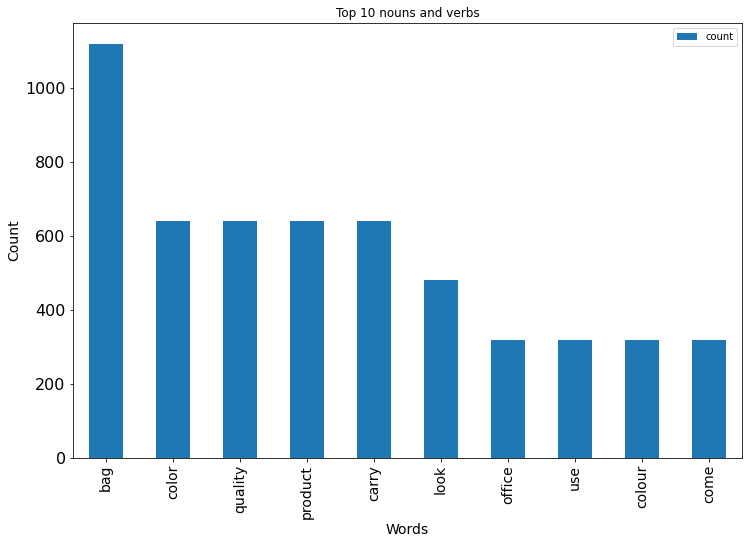

In [134]:
wd_df[0:10].plot.bar(x='word',figsize=(12,8),title='Top 10 nouns and verbs', fontsize=16)
plt.xticks(rotation=90,fontsize=14)
plt.xlabel('Words', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.show()

#### Feature Extraction

##### BOW Features

In [135]:
bow_word_vectorizer = CountVectorizer(max_df=0.90, min_df=2, stop_words='english')
# bag-of-words feature matrix
bow_word_feature = bow_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

#### TF-IDF Features

In [136]:
tfidf_word_vectorizer = TfidfVectorizer(max_df=0.90, min_df=2, stop_words='english')
# TF-IDF feature matrix
tfidf_word_feature = tfidf_word_vectorizer.fit_transform(dataframe['Clean_Reviews'])

#### Fetch sentiments Using TextBlob

In [137]:
def fetch_sentiment_using_textblob(text):
    analysis = TextBlob(text)
    return 'pos' if analysis.sentiment.polarity >= 0 else 'neg'

In [138]:
sentiments_using_textblob = dataframe.Clean_Reviews.apply(lambda reviews_text: fetch_sentiment_using_textblob(reviews_text))
pd.DataFrame(sentiments_using_textblob.value_counts())

,Clean_Reviews
pos,1280
neg,320


#### Let's calculate subjectivity and Polarity

In [139]:
def calc_subj(text):
    return TextBlob(text).sentiment.subjectivity
 
# function for Polarity
def calc_pola(text):
    return TextBlob(text).sentiment.polarity
 
dataframe['Subjectivity'] = dataframe.Clean_Reviews.apply(calc_subj)
dataframe['Polarity'] = dataframe.Clean_Reviews.apply(calc_pola)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews,Subjectivity,Polarity
0,liked,liked,[liked],0.800000,0.600000
1,slightly bigger expected,slightly bigger expected,"[slightly, bigger, expected]",0.450000,-0.050000
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...,"[looking, slightly, big, purse, office, purpos...",0.685185,0.422222
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ...","[overall, bag, good, however, truly, disappoin...",0.450000,-0.016667
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col...","[quality, premium, look, sexy, forgot, old, ba...",0.580000,0.300000


Text(0, 0.5, 'Subjectivity')

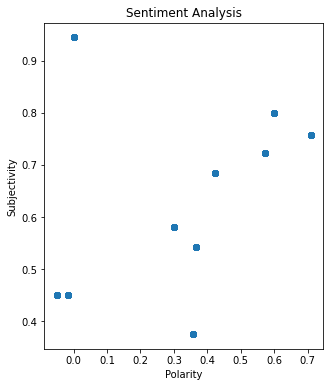

In [142]:
f, axes = plt.subplots(figsize = (5,6))
plt.scatter(dataframe.Polarity, dataframe.Subjectivity)
plt.title('Sentiment Analysis')
plt.xlabel('Polarity')
plt.ylabel('Subjectivity')

In [141]:
dataframe['sentiment'] = sentiments_using_textblob
dataframe.to_csv("clean_review.csv",index=False)
dataframe.head()

,Clean_Reviews,Uncleaned_Reviews,Tokenized_Reviews,Subjectivity,Polarity,sentiment
0,liked,liked,[liked],0.800000,0.600000,pos
1,slightly bigger expected,slightly bigger expected,"[slightly, bigger, expected]",0.450000,-0.050000,neg
2,looking slightly big purse office purpose bag ...,looking slightly big purse office purpose. bag...,"[looking, slightly, big, purse, office, purpos...",0.685185,0.422222,pos
3,overall bag good however truly disappointed pa...,"overall bag good. however, truly disappointed ...","[overall, bag, good, however, truly, disappoin...",0.450000,-0.016667,neg
4,quality premium look sexy forgot old bag color...,"quality premium look sexy forgot old bags, col...","[quality, premium, look, sexy, forgot, old, ba...",0.580000,0.300000,pos


#### Story Generation and Visualization

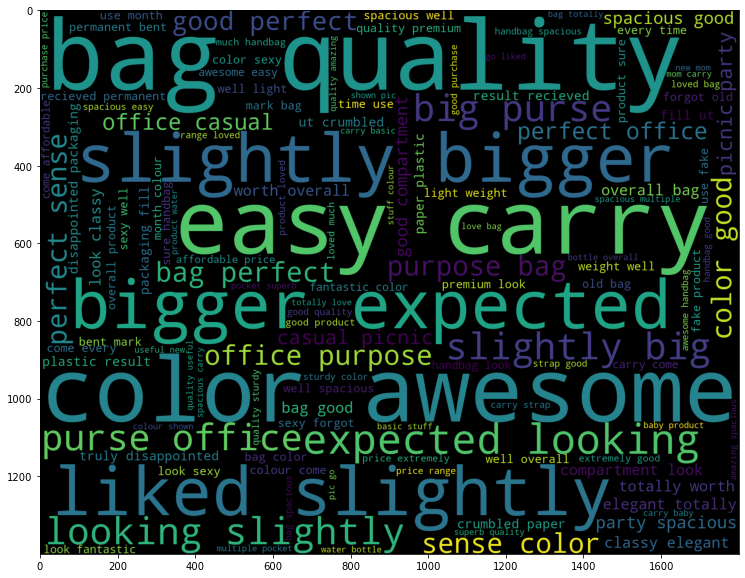

In [143]:
allWords_ = ' '.join([review for review in dataframe[:500]['Clean_Reviews']])
f, axes = plt.subplots(figsize=(14,10))
wordcloud= WordCloud(background_color = 'black', width = 1800, height =1400).generate(allWords_)
plt.imshow(wordcloud);

#### Most common words in positive Review

In [147]:
def generate_wordcloud(all_words):
    wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=100, relative_scaling=0.5, colormap='Dark2').generate(all_words)

    plt.figure(figsize=(14,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis('off')
    plt.show()

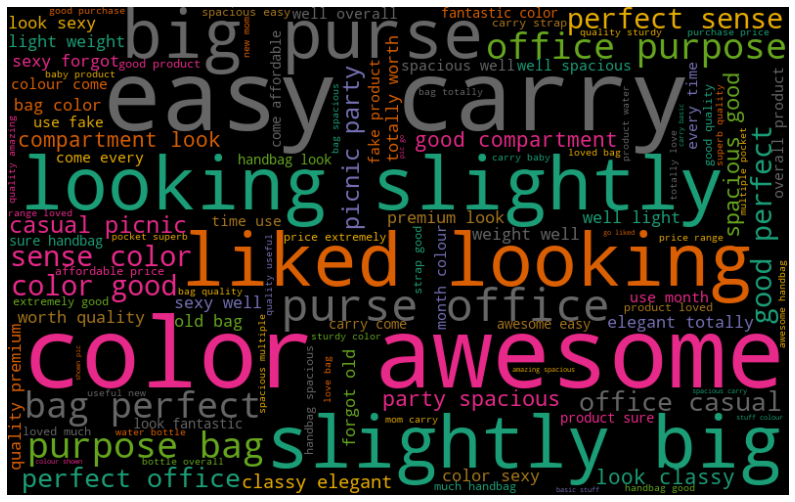

In [148]:
all_words = ' '.join([text for text in dataframe['Clean_Reviews'][dataframe.sentiment == 'pos']])
generate_wordcloud(all_words)


#### Most common words in negative Review

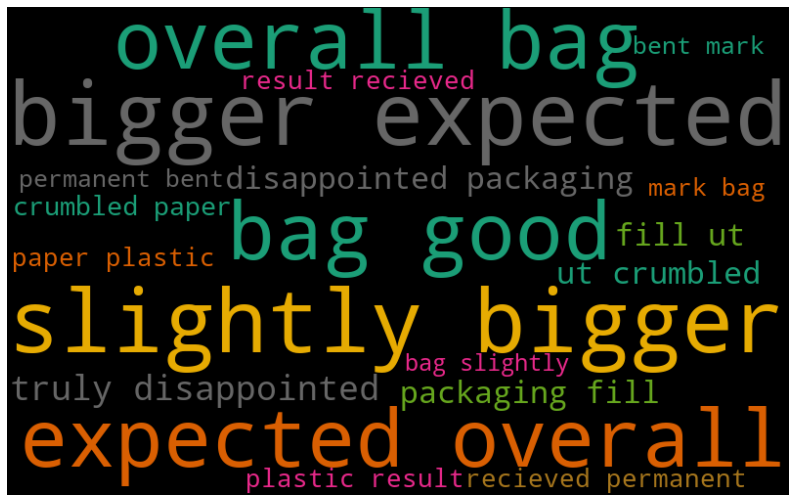

In [149]:
all_words = ' '.join([text for text in dataframe['Clean_Reviews'][dataframe.sentiment == 'neg']])
generate_wordcloud(all_words)
